# Purpose of the notebook

We showed in the notebook "method_evaluation" that the best method for switchback test analysis it CRSE. In this notebook, we use the CRSE to calculate the confidence interval of the effect for different datasets. We start with data on country-level, move to city-level and finally analyse 4 "realistic dataset" on which we really would run a switchback test.

# Imports

In [6]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import seaborn as sns
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
from tqdm import tqdm
import statsmodels.formula.api as smf
import pandas as pd
tqdm.pandas()

/Users/o.weisse/switchback_test_dag/venv/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


# Sample sizes (no. orders) per country in two weeks

In [7]:
client = bigquery.Client(project = 'logistics-data-staging-flat')

In [3]:
query = """
SELECT
entity_id,
count(*) number_of_orders
FROM `fulfillment-dwh-production.cl.orders_v2`orders
WHERE created_date BETWEEN "2023-05-01" AND "2023-05-14"
GROUP BY entity_id
ORDER BY number_of_orders
"""

In [4]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

NameError: name 'bigquery_storage' is not defined

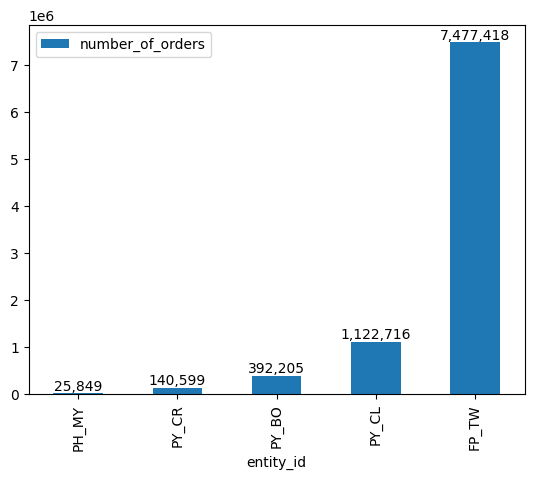

In [5]:
ax = data[data['entity_id'].isin(['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"])].set_index('entity_id').plot.bar()

# Add numbers above the bars
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',')), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

We have a very big difference in orders for different entities. Note that the number of orders for PY_CR and FP_TW is in different orders of magnitude.

# Download Data

In [3]:
def download_data(entity_ids, start_date, end_date):
    query = f"""
    SELECT
    entity_id,
    rider.city_id,
    created_date,
    created_at,
    orders.rider.timings.actual_delivery_time/60 delivery_time,
    orders.rider.timings.order_delay/60 order_delay,
    orders.rider.timings.bag_time/60 bag_time,
    --ARRAY(SELECT d.dropoff_distance_manhattan FROM UNNEST(orders.rider.deliveries) AS d)[OFFSET(0)] distance,
    FROM `fulfillment-dwh-production.cl.orders_v2`orders
    WHERE created_date BETWEEN "{start_date}" AND "{end_date}"
    AND entity_id in {tuple(entity_ids)}
    """

    bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
    data = client.query(query).result()\
    .to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')
    return data

In [7]:
entity_ids = ['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"]
start_date = "2023-05-01"
end_date = "2023-05-14"
data = download_data(entity_ids, start_date, end_date)

Downloading:   0%|          | 0/9158787 [00:00<?, ?rows/s]

In [8]:
KPI = "delivery_time"

In [9]:
# filter
data = data[data['delivery_time']<120]
data = data[data['delivery_time']>0]
data = data[data[KPI].notnull()]

<AxesSubplot:xlabel='delivery_time', ylabel='Density'>

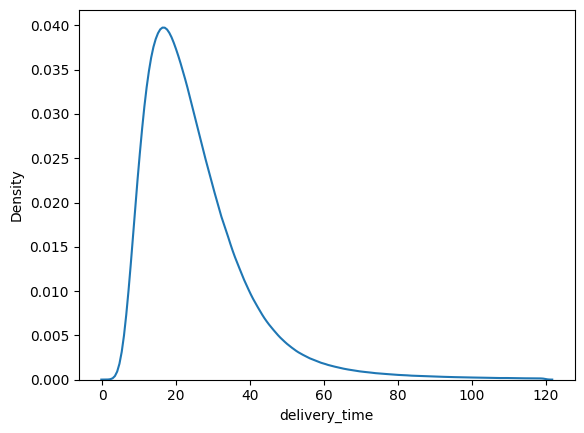

In [288]:
sns.kdeplot(data[KPI])

In [10]:
data[KPI].mean()

25.32630921140975

# Confidence Intervals per window size

In [23]:
def randomize_time_unit_assignment(data, proportion=0.5):
    """Creates a new columns called 'group'. Assigns each time unit randomly to either group A or B."""
    time_unit_group_dict = {i: np.random.choice(['A', 'B'], p=[1-proportion, proportion]) for i in data.time_unit.unique()}
    data['group'] = data['time_unit'].map(time_unit_group_dict)

In [24]:
def CRSE_CI(data, KPI):
    """Calculates the CI for cluster robust standard error method."""
    data["group_binary"] = data['group'].map({"A":0, "B": 1})
    model = smf.ols(formula=f'{KPI} ~ group_binary', data=data)
    results = model.fit(cov_type="cluster", cov_kwds={'groups': data['time_unit']})
    std_err = results.bse["group_binary"]
    mean_diff = results.params["group_binary"]
    return std_err, mean_diff

In [14]:
# assign to group with hourly switchback interval
data['time_unit'] = data['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data)

In [15]:
# calculate CIs
results = data.groupby('entity_id').progress_apply(lambda data: 2*CRSE_CI(data, KPI)[0])
results.name = "CI"

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.37s/it]


Text(0.5, 1.0, '95% confidence intervals for a 50:50 split on all orders')

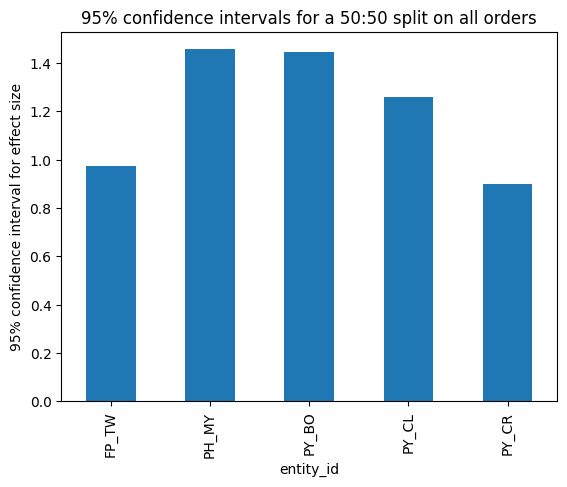

In [16]:
results.plot.bar()
plt.ylabel("95% confidence interval for effect size")
plt.title("95% confidence intervals for a 50:50 split on all orders")

Although we have many more orders for FP_TW than for PY_CR, we have a smaller CI for PY_CR.

In [17]:
mean_KPI = data.groupby('entity_id')['delivery_time'].mean()
mean_KPI.name = 'mean'
results = pd.concat([results, mean_KPI], axis=1)

We can also check the relative CI in the following plot.

Text(0.5, 1.0, '95% relative confidence intervals for a 50:50 split on all orders (in %)')

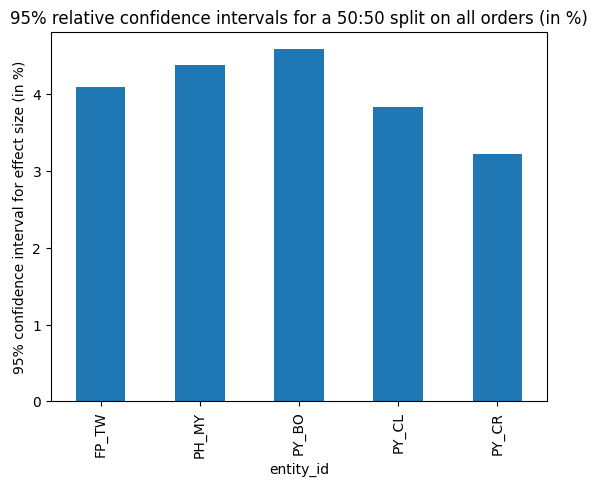

In [18]:
(100*(results['CI']/results['mean'])).plot.bar()
plt.ylabel("95% confidence interval for effect size (in %)")
plt.title("95% relative confidence intervals for a 50:50 split on all orders (in %)")

The following plot shows that the hourly fluctuation are bigger for TW than for CR. The learning from the example is that for switchback tests the number of orders is way less important than what the size of the fluctuations are.

In [19]:
grouped_data = data.groupby(['time_unit', 'entity_id'])[KPI].mean().unstack()

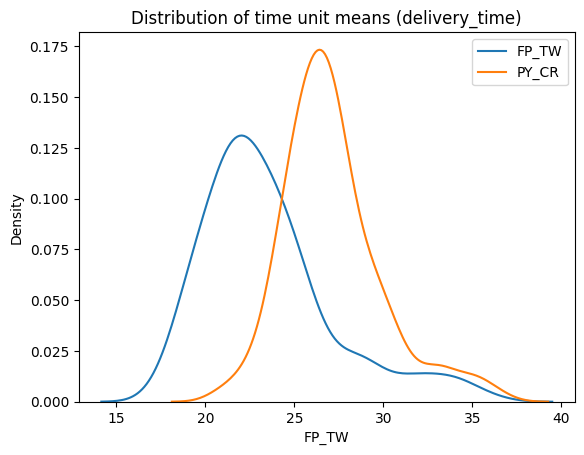

In [20]:
sns.kdeplot(grouped_data['FP_TW'])
sns.kdeplot(grouped_data['PY_CR'])
plt.title(f'Distribution of time unit means ({KPI})')
plt.legend(['FP_TW', "PY_CR"])

Text(0.5, 1.0, 'time unit means over time')

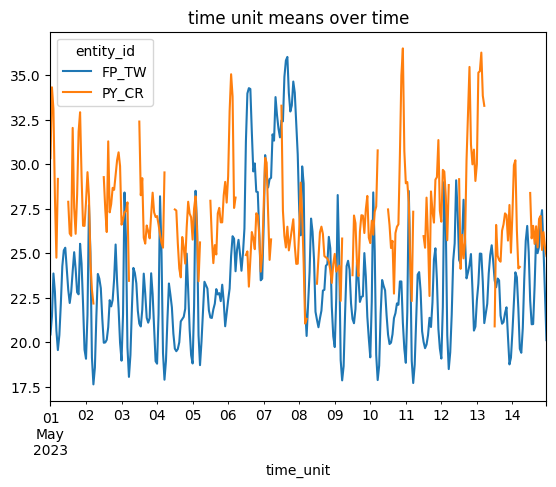

In [21]:
grouped_data[["FP_TW", "PY_CR"]].plot()
plt.title('DT (delivery time) time unit means over time')

# Increase length of test

In [274]:
entity_ids = ['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"]
start_date = "2023-05-01"
end_date = "2023-06-01"
data_long_test = download_data(entity_ids, start_date, end_date)

Downloading:   0%|          | 0/20681768 [00:00<?, ?rows/s]

In [275]:
# filter
data_long_test = data_long_test[data_long_test['delivery_time']<120]
data_long_test = data_long_test[data_long_test['delivery_time']>0]
data_long_test = data_long_test[data_long_test[KPI].notnull()]

In [276]:
# assign to group with hourly switchback interval
data_long_test['time_unit'] = data_long_test['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data_long_test)

In [277]:
# calculate CIs
results = data_long_test.groupby('entity_id').progress_apply(lambda data: 2*CRSE_CI(data_long_test, KPI)[0])
results.name = "CI"

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.23s/it]


Text(0.5, 1.0, '95% confidence intervals for a 50:50 split on all orders')

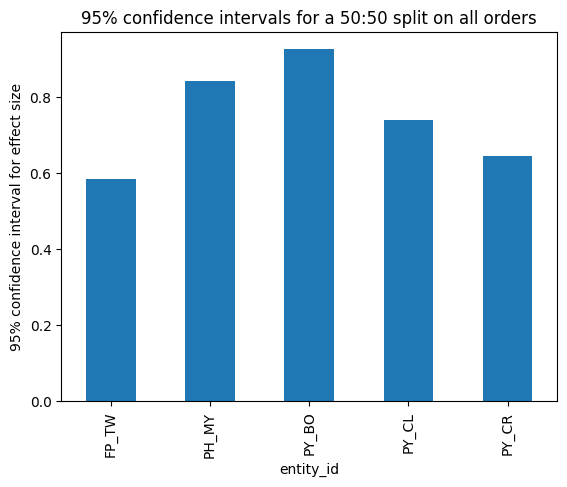

In [278]:
results.plot.bar()
plt.ylabel("95% confidence interval for effect size")
plt.title("95% confidence intervals for a 50:50 split on all orders")

In [279]:
mean_KPI = data_long_test.groupby('entity_id')['delivery_time'].mean()
mean_KPI.name = 'mean'
results = pd.concat([results, mean_KPI], axis=1)

Text(0.5, 1.0, '95% relative confidence intervals for a 50:50 split on all orders (in %)')

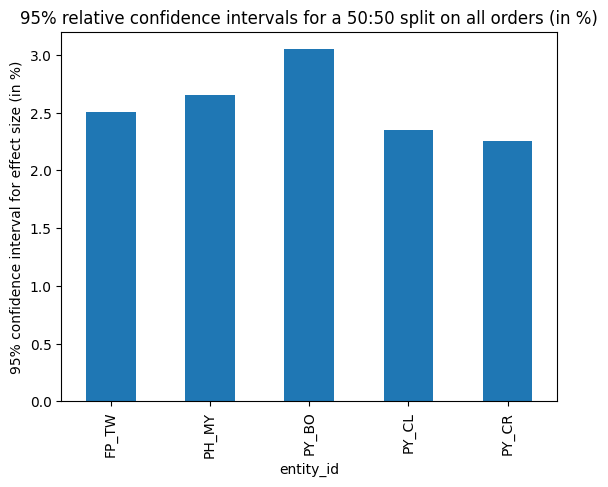

In [280]:
(100*(results['CI']/results['mean'])).plot.bar()
plt.ylabel("95% confidence interval for effect size (in %)")
plt.title("95% relative confidence intervals for a 50:50 split on all orders (in %)")

We can see that prolonging the length of the test is very effective to improve the sensitivity of the test.

# City level

In [27]:
# assign to group with hourly switchback interval
data['time_unit'] = data['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data)

data['entity_city_id'] = data['entity_id']+data['city_id'].astype(str)

In [28]:
# calculate CIs
results = data.groupby('entity_city_id').progress_apply(lambda data: 2*CRSE_CI(data, KPI)[0])
results.name = "CI"

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:56<00:00,  1.39it/s]


Text(0.5, 1.0, '95% confidence intervals for a 50:50 split on all orders')

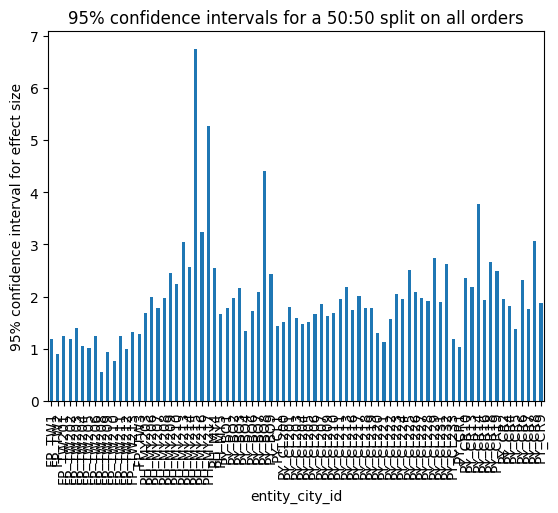

In [29]:
results.plot.bar()
plt.ylabel("95% confidence interval for effect size")
plt.title("95% confidence intervals for a 50:50 split on all orders")

In [32]:
mean_KPI = data.groupby('entity_city_id')['delivery_time'].mean()
mean_KPI.name = 'mean'
results = pd.concat([results, mean_KPI], axis=1)

Text(0.5, 1.0, '95% relative confidence intervals for a 50:50 split on all orders (in %)')

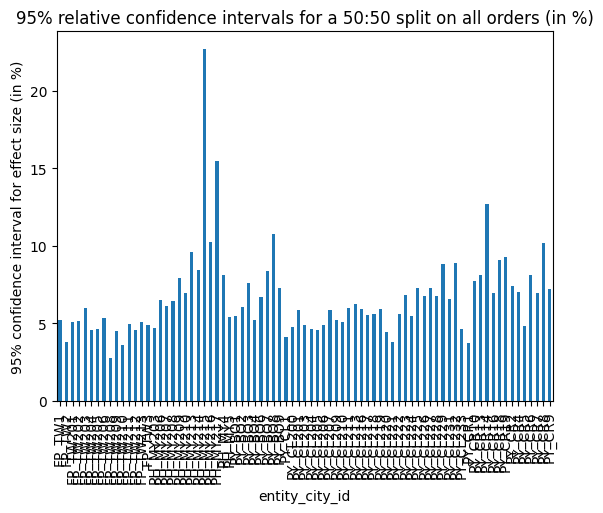

In [34]:
(100*(results['CI']/results['mean'])).plot.bar()
plt.ylabel("95% confidence interval for effect size (in %)")
plt.title("95% relative confidence intervals for a 50:50 split on all orders (in %)")

# Realistic datasets for surge test

We now move on to datasets on which we really might do a switchback test and report the confidence interval. In practise we want to measure an effect that is higher than the CI.

## Cambodia - FP_KH, city Siem reap, zone Siem reap, ASA ID 5

In [13]:
query = """
SELECT
*
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
WHERE
entity_id = "FP_KH" AND assignment_id = 5 AND 
created_date BETWEEN "2023-06-11" AND "2023-07-11" 
AND vendor_price_scheme_type = "Automatic scheme"
"""

In [14]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data_KH = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/53925 [00:00<?, ?rows/s]

In [15]:
data_KH = data_KH[data_KH['actual_DT'].notnull()]
data_KH = data_KH[data_KH['delivery_distance_m'].notnull()]
data_KH['dps_mean_delay'] = data_KH['dps_mean_delay'].astype(float) 

In [16]:
# assign to group with hourly switchback interval
data_KH['time_unit'] = data_KH['order_placed_at'].dt.floor("1H")

In [17]:
data_KH.name = 'FP_KH, city Siem reap, zone Siem reap, ASA ID 5'

## Laos - FP_LA, city Luang prabang, zone Luang prabang, ASA ID 6

In [8]:
query = """
SELECT
*
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
WHERE
entity_id = "FP_LA" AND assignment_id = 6 AND 
created_date BETWEEN "2023-01-01" AND "2023-02-01"
AND vendor_price_scheme_type = "Automatic scheme"
"""

In [9]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data_LA = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/12272 [00:00<?, ?rows/s]

In [10]:
data_LA = data_LA[data_LA['actual_DT'].notnull()]
data_LA = data_LA[data_LA['delivery_distance_m'].notnull()]
data_LA['dps_mean_delay'] = data_LA['dps_mean_delay'].astype(float)

In [11]:
# assign to group with hourly switchback interval
data_LA['time_unit'] = data_LA['order_placed_at'].dt.floor("1H")

In [12]:
data_LA.name = 'FP_LA, city Luang prabang, zone Luang prabang, ASA ID 6'

### Delivery Time

In [18]:
KPI = 'actual_DT'

In [19]:
datasets = [data_KH, data_LA]

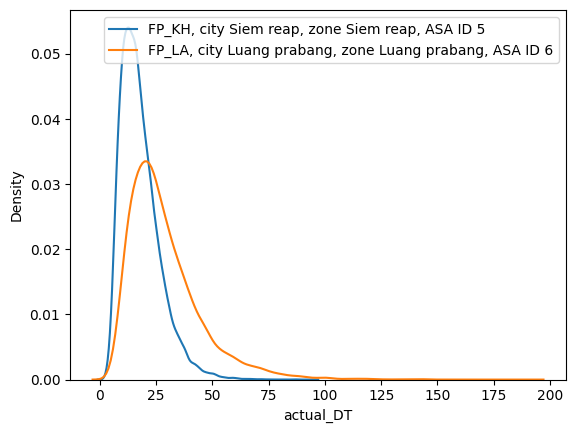

In [20]:
for data in datasets:
    sns.kdeplot(data[KPI])
plt.legend([data_KH.name, data_LA.name])

In [21]:
def get_results(data, KPI):
    """Calculates the 95% CI for a chosen dataset and KPI. If we do not affect all orders, we need to multiply the
    CI by 1 over the proportion of orders that we affect."""
    randomize_time_unit_assignment(data, proportion=0.5)
    CI = 2*CRSE_CI(data, KPI)[0]
    
    CIs = []
    orders_affected_list = [50, 30, 20, 10, 5]
    for orders_affected in orders_affected_list:
        CIs.append(CI*100/orders_affected)
    results = pd.Series(CIs, index=[str(i)+"%" for i in orders_affected_list])
    return results

In [25]:
results = pd.DataFrame()
results_relative = pd.DataFrame()
for data in datasets:
    results[data.name] = get_results(data, KPI)
    results_relative[data.name] = 100*get_results(data, KPI)/data[KPI].mean()

Text(0.5, 0, '% of orders affected by surge')

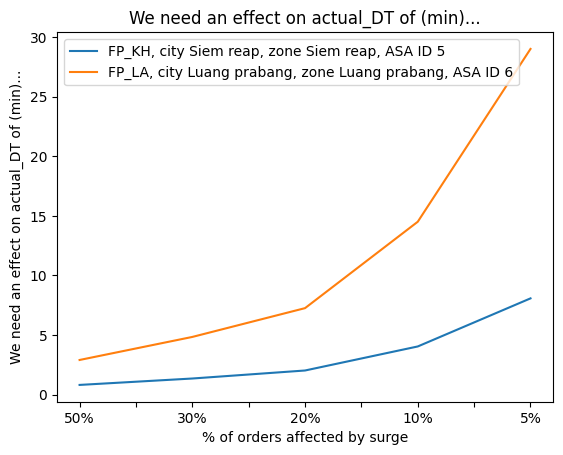

In [26]:
results.plot()
plt.title(f'We need an effect on {KPI} of (min)...')
plt.ylabel(f'We need an effect on {KPI} of (min)...')
plt.xlabel('% of orders affected by surge')

Text(0.5, 0, '% of orders affected by surge')

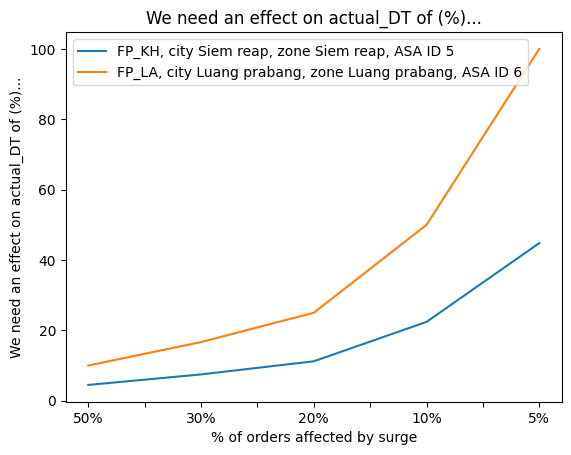

In [27]:
results_relative.plot()
plt.title(f'We need an effect on {KPI} of (%)...')
plt.ylabel(f'We need an effect on {KPI} of (%)...')
plt.xlabel('% of orders affected by surge')

### Distance

In [209]:
KPI = 'delivery_distance_m'

In [210]:
datasets = [data_KH, data_LA]

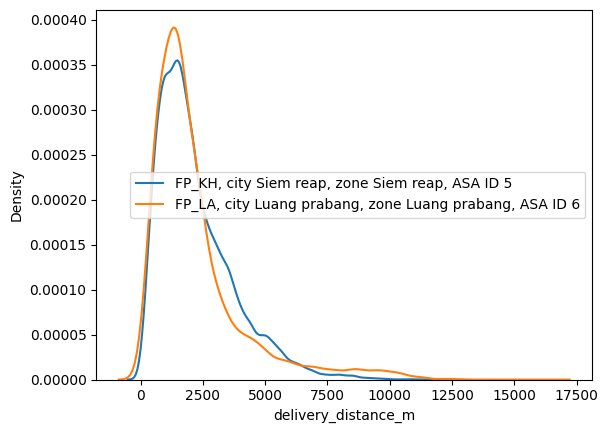

In [211]:
for data in datasets:
    sns.kdeplot(data[KPI])
plt.legend([data_KH.name, data_LA.name])

In [212]:
results = pd.DataFrame()
results_relative = pd.DataFrame()
for data in datasets:
    results[data.name] = get_results(data, KPI)
    results_relative[data.name] = 100*get_results(data, KPI)/data[KPI].mean()

Text(0.5, 0, '% of orders affected by surge')

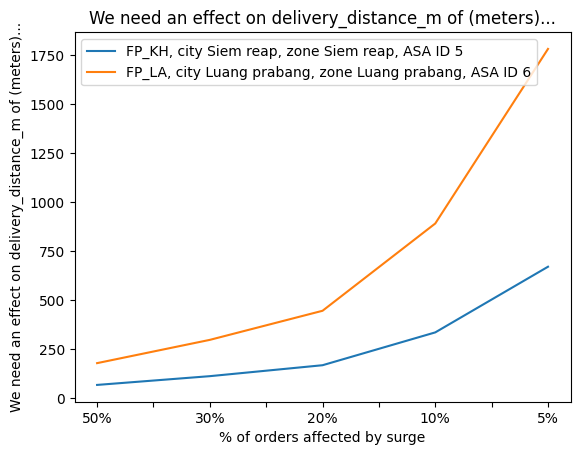

In [214]:
results.plot()
plt.title(f'We need an effect on {KPI} of (meters)...')
plt.ylabel(f'We need an effect on {KPI} of (meters)...')
plt.xlabel('% of orders affected by surge')

Text(0.5, 0, '% of orders affected by surge')

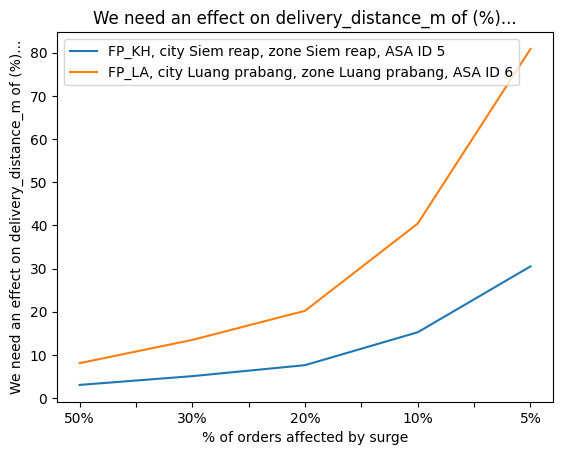

In [216]:
results_relative.plot()
plt.title(f'We need an effect on {KPI} of (%)...')
plt.ylabel(f'We need an effect on {KPI} of (%)...')
plt.xlabel('% of orders affected by surge')

### dps_mean_delay

In [224]:
KPI = 'dps_mean_delay'

In [225]:
datasets = [data_KH, data_LA]

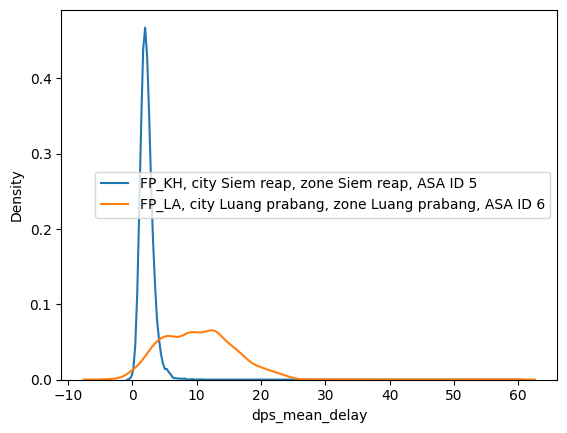

In [226]:
for data in datasets:
    sns.kdeplot(data[KPI])
plt.legend([data_KH.name, data_LA.name])

In [238]:
results = pd.DataFrame()
results_relative = pd.DataFrame()
for data in datasets:
    results[data.name] = get_results(data, KPI)
    results_relative[data.name] = 100*get_results(data, KPI)/data[KPI].mean()

Text(0.5, 0, '% of orders affected by surge')

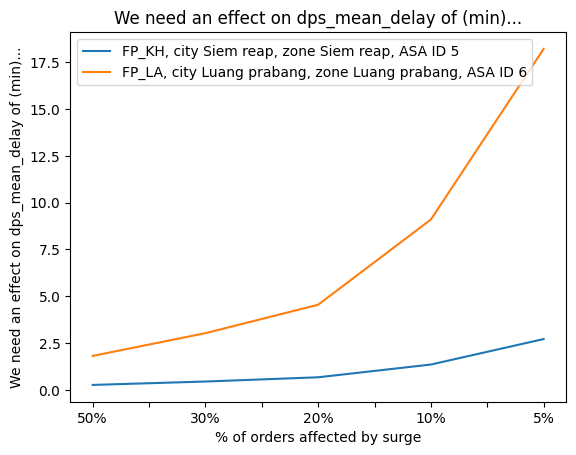

In [239]:
results.plot()
plt.title(f'We need an effect on {KPI} of (min)...')
plt.ylabel(f'We need an effect on {KPI} of (min)...')
plt.xlabel('% of orders affected by surge')

Text(0.5, 0, '% of orders affected by surge')

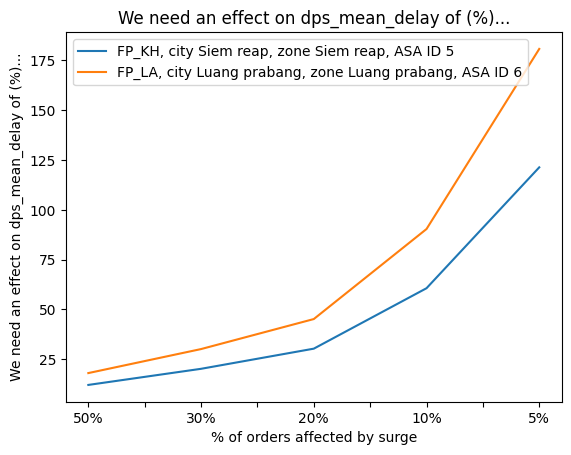

In [240]:
results_relative.plot()
plt.title(f'We need an effect on {KPI} of (%)...')
plt.ylabel(f'We need an effect on {KPI} of (%)...')
plt.xlabel('% of orders affected by surge')

# Best switchback intervals

We check for different KPIs what the best switchback interval is.

In [292]:
def get_CIs_for_different_window_sizes(data, KPI, window_sizes):
    """Calculates confidence intervals for a certain method for different specified window_sizes."""
    CIs = []
    for window_size in tqdm(window_sizes):
        data['time_unit'] = data['order_placed_at'].dt.floor(window_size)
        randomize_time_unit_assignment(data)
        CI, _ = CRSE_CI(data, KPI)
        CIs.append(2*CI)
    return pd.Series(CIs, index=window_sizes, name=data.name)

In [293]:
window_sizes = [str(i)+"H" for i in range(1,12)]+["1D", "2D", "3D"]

results = pd.DataFrame()

for KPI in ['actual_DT', 'delivery_distance_m', 'dps_mean_delay']:
    CIs = get_CIs_for_different_window_sizes(data_KH, KPI, window_sizes)
    results[KPI] = 100*CIs/data_KH[KPI].mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.50it/s]


Text(0.5, 1.0, 'Confidence Interval for effect (%) for different switchback intervals')

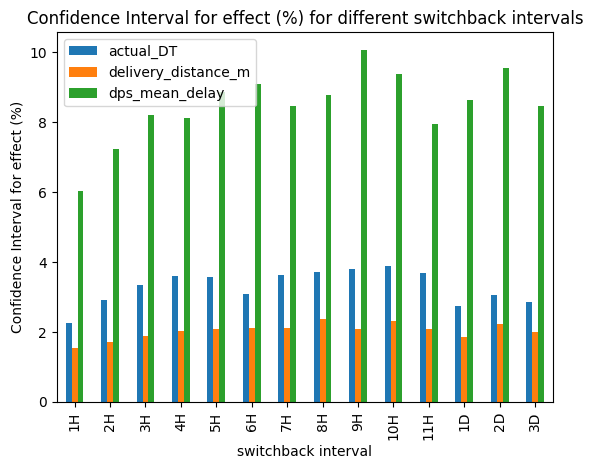

In [309]:
results.plot.bar()
plt.xlabel("switchback interval")
plt.ylabel("Confidence Interval for effect (%)")
plt.title("Confidence Interval for effect (%) for different switchback intervals")

Text(0.5, 1.0, 'CI for effect on DT (%) for different switchback intervals')

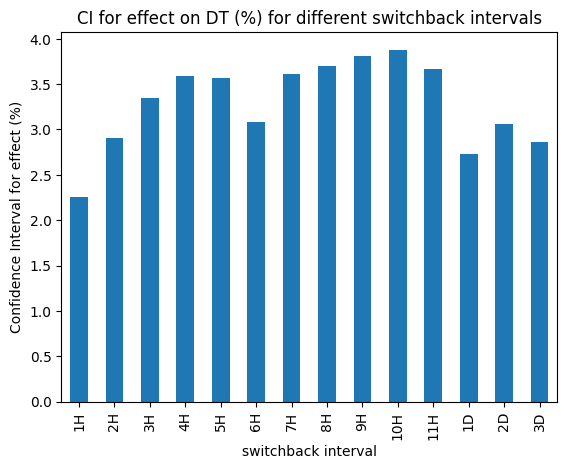

In [312]:
results['actual_DT'].plot.bar()
plt.xlabel("switchback interval")
plt.ylabel("Confidence Interval for effect (%)")
plt.title("CI for effect on DT (%) for different switchback intervals")

A lower switchback interval does not mean that we get a better CI. The size of the CI depends on the fluctuations that we have on the time unit level. This needs to be determined experimentally before a test. That being said, in all of the datasets that we analysed, the 1-hour switchback interval performed best.